# 4.3 受控运算

本节的习题也可以参考 Qiskit 网站：

> https://qiskit.org/textbook/ch-gates/more-circuit-identities.html

In [1]:
import numpy as np
from opt_einsum import contract as einsum
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import warnings

np.set_printoptions(4, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
# Vector in computational basis
vec0 = np.array([1, 0])
vec1 = np.array([0, 1])
# Matrices in computational basis
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
T = np.array([[1, 0], [0, np.exp(1j*np.pi/4)]])
S = T @ T
P0 = np.outer(vec0, vec0)
P1 = np.outer(vec1, vec1)

## 预练习：受控门的张量积表示

:::{admonition} 预练习

请表明可以作用于 $|x_1x_2\rangle$ 的、以 $x_1$ 为控制量子比特、以 $x_2$ 为目标量子比特的受控非门 $\mathrm{CNOT}_{x_1, x_2}$ 可以表示为

$$
\mathrm{CNOT}_{x_1, x_2} = P_0 \otimes I + P_1 \otimes X
$$

其中，$P_0, P_1$ 是计算基下的投影算符：

$$
P_0 = | 0 \rangle \langle 0 |, \quad P_1 = | 1 \rangle \langle 1 |
$$

:::

我们以后经常会使用这类受控门的张量积表示，来进行证明或计算。该控制门的图示是 ($x_1, x_2$ 对应到下图的 $q_0, q_1$)

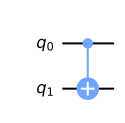

In [3]:
circ = QuantumCircuit(2)
circ.cx(0, 1)
circ.draw()

**证明 1**

我们令待证等式右边为算符 $A = P_0 \otimes I + P_1 \otimes X$ 。将 $A$ 作用于两个量子比特 $x_1, x_2$ 所构成的态 $|x_1 x_2\rangle$ 上：

$$
A |x_1 x_2\rangle = P_0 |x_1\rangle \otimes I |x_2\rangle + P_1 |x_1\rangle \otimes X |x_2\rangle
$$

我们只需要考虑 $|x_1 x_2\rangle$ 为计算基 $\{ |00\rangle, |01\rangle, |10\rangle, |11\rangle \}$ 的情况。

- 若 $|x_1\rangle = |0\rangle$，那么 $P_0 |0\rangle = |0\rangle$ 且 $P_0 |0\rangle = 0$。因此，
    
    $$
    A |0 x_2\rangle = |0\rangle \otimes I |x_2\rangle = |0x_2\rangle
    $$
    
    这意味着如果 $|x_1\rangle = |0\rangle$，那么经过算符 $A$ 的作用后，$|x_2\rangle$ 仍然保持不变。

- 若 $|x_1\rangle = |1\rangle$，那么 $P_0 |1\rangle = 0$ 且 $P_1 |1\rangle = |1\rangle$。因此，
    
    $$
    A |1 x_2\rangle = |1\rangle \otimes X |x_2\rangle
    $$
    
    这意味着如果 $|x_1\rangle = |1\rangle$，那么经过算符 $A$ 的作用后，$|x_2\rangle$ 会变成 $X |x_2\rangle$，即将非门作用于 $|x_2\rangle$。

因此，算符 $A$ 完全符合受控非门的定义。

对于上述的计算过程，请不要搞混 $x_1, x_2$ 的下标与 $|0\rangle, |1\rangle$。

**证明 2**

直接计算等式右的 $P_0 \otimes I + P_1 \otimes Z$，并验证它是否是书中式 (4.23) 所表示的矩阵：

\begin{equation*}
\mathrm{CNOT}_{x_1, x_2} = \begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
\tag{4.23}
\end{equation*}

求取张量积 (Kronecker tensor product) 的过程实际上也可以通过 `np.kron` 函数实现。

In [4]:
np.kron(P0, I) + np.kron(P1, X)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

**补充**

我们有时还需要用以 $x_2$ 为控制量子比特、以 $x_1$ 为目标量子比特的受控非门 $\mathrm{CNOT}_{x_1, x_2}$。其表示是

$$
\mathrm{CNOT}_{x_2, x_1} = I \otimes P_0 + X \otimes P_1
$$

请注意相对于 $\mathrm{CNOT}_{x_1, x_2}$，上式的变化**不是** $P_0$ 与 $P_1$ 交换，而是张量积的顺序发生了变化。其图示是 ($x_1, x_2$ 对应到下图的 $q_0, q_1$)

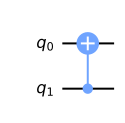

In [5]:
circ = QuantumCircuit(2)
circ.cx(1, 0)
circ.draw()

## 练习 4.16 (多量子比特门的矩阵表示)

:::{admonition} 练习 4.16

在计算基下，如下线路的 $4 \times 4$ 酉矩阵是什么？

![ex-4.16.1](assets/ex-4.16.1.svg)

如下线路在计算基下的酉矩阵是什么？

![ex-4.16.2](assets/ex-4.16.2.svg)

:::

这里有意将原书中的 $x_1, x_2$ 颠倒过来。一般来说，不管是程序还是书中，排在上面的线路的量子比特序号都比较小。

在这一小节中，我们会尽量同时使用 qiskit 来绘制线路图，以熟悉程序的编写。

第一个线路的酉矩阵是

$$
H \otimes I = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
1 & 0 & -1 & 0 \\
0 & 1 & 0 & -1 \\
\end{bmatrix}
$$

In [6]:
np.kron(H, I)

array([[ 0.7071,  0.    ,  0.7071,  0.    ],
       [ 0.    ,  0.7071,  0.    ,  0.7071],
       [ 0.7071,  0.    , -0.7071, -0.    ],
       [ 0.    ,  0.7071, -0.    , -0.7071]])

该线路的绘制可以通过下述代码实现：

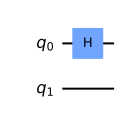

In [7]:
circ = QuantumCircuit(2)
circ.h(0)
circ.draw()

第二个线路的酉矩阵是

$$
I \otimes H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 & 0 & 0 \\
1 & -1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 0 & 1 & -1 \\
\end{bmatrix}
$$

In [8]:
np.kron(I, H)

array([[ 0.7071,  0.7071,  0.    ,  0.    ],
       [ 0.7071, -0.7071,  0.    , -0.    ],
       [ 0.    ,  0.    ,  0.7071,  0.7071],
       [ 0.    , -0.    ,  0.7071, -0.7071]])

该线路的绘制可以通过下述代码实现：

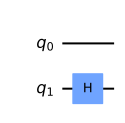

In [9]:
circ = QuantumCircuit(2)
circ.h(1)
circ.draw()

## 练习 4.17 (由受控 $Z$ 门建造受控非门)

:::{admonition} 练习 4.17

从一个受控 $Z$ 门 (即一个在计算基下的作用由如下酉矩阵表示)

$$
\text{ctrl-}Z = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{bmatrix}
$$

和两个 Hadamard 门构造一个受控非门，并指定控制量子比特和目标量子比特。

:::

该练习是多解题。我们将在练习 4.18 中证明到

![ex-4.17.1](assets/ex-4.17.1.svg)

因此，对于受控 $Z$ 门而言，控制量子比特和目标量子比特是完全等价的。我们将受控 $Z$ 门的矩阵表示用程序变量 `ctrl_Z` 写出。

In [10]:
ctrl_Z = np.kron(P0, I) + np.kron(P1, Z)
ctrl_Z

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]])

受控非门 CNOT 是受控 $X$ 门，依据控制量子比特是 $x_1$ 或 $x_2$、目标量子比特是 $x_2$ 或 $x_1$，我们可能写出两种 CNOT 的矩阵表示，分别用变量 $\mathrm{CNOT}_{x_1, x_2}$ `ctrl_1_X` 与 $\mathrm{CNOT}_{x_2, x_1}$ `ctrl_2_X` 写出。

In [11]:
ctrl_1_X = np.kron(P0, I) + np.kron(P1, X)
ctrl_2_X = np.kron(I, P0) + np.kron(X, P1)
ctrl_1_X, ctrl_2_X

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]]))

我们很容易地可以凑出下述结果：

![ex-4.17.2](assets/ex-4.17.2.svg)

用数学的方式来表达上述过程，则是

$$
\begin{align*}
(I \otimes H) \, \text{ctrl-}Z \, (I \otimes H) &= \mathrm{CNOT}_{x_1, x_2} \\
(I \otimes H) (P_0 \otimes I + P_1 \otimes Z) (I \otimes H) &= P_0 \otimes I + P_1 \otimes X
\end{align*}
$$

有两种证明方法。第一种是给出所有矩阵表示并作验证：

In [12]:
np.allclose(np.kron(I, H) @ ctrl_Z @ np.kron(I, H), ctrl_1_X)

True

第二种方法是作代数证明。回顾到 $HZH = X, H^2 = I$，因此

$$
\begin{align*}
&\quad (I \otimes H) (P_0 \otimes I + P_1 \otimes Z) (I \otimes H) \\
&= (I P_0 I) \otimes (H I H) + (I P_1 I) \otimes (H Z H) \\
&= P_0 \otimes I + P_1 \otimes X
\end{align*}
$$

证明完毕。

其中一个门路的图像可以绘制如下 ($x_1, x_2$ 对应到下图的 $q_0, q_1$)：

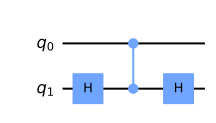

In [13]:
circ = QuantumCircuit(2)
circ.h(1); circ.cz(0, 1); circ.h(1)
circ.draw()

由于受控 $Z$ 门实际上是关于控制与目标量子比特 $x_1, x_2$ 对称的，因此也很容易地给出另一种情况：

![ex-4.17.3](assets/ex-4.17.3.svg)

## 练习 4.18

:::{admonition} 练习 4.18

证明下图：

![ex-4.18.1](assets/ex-4.18.1.svg)

:::

回顾到预练习，用数学的语言表述，该题希望证明

$$
P_0 \otimes I + P_1 \otimes Z = I \otimes P_0 + Z \otimes P_1
$$

这个证明恐怕还是需要用矩阵表示做比较方便：

In [14]:
np.allclose(
    np.kron(P0, I) + np.kron(P1, Z),
    np.kron(I, P0) + np.kron(Z, P1))

True

但也可以使用代数做法。我们可以利用下述结论：

$$
P_0 = \frac{I+Z}{2} = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}, \quad P_1 = \frac{I-Z}{2} = \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}
$$

因此，

$$
\begin{align*}
&\quad P_0 \otimes I + P_1 \otimes Z \\
&= \frac{1}{2} \big( (I + Z) \otimes I + (I - Z) \otimes Z \big) \\
&= \frac{1}{2} \big( I \otimes I + Z \otimes I + I \otimes Z - Z \otimes Z \big) \\
&= \frac{1}{2} \big( I \otimes (I+Z) + Z \otimes (I-Z) \big) \\
&= I \otimes P_0 + Z \otimes P_1
\end{align*}
$$

因此，受控 $Z$ 门是关于两个量子比特对称的。一般来说，它的图像不使用方块圈起来的 $Z$ 给出，而是像下图一样 (也可以回顾练习 4.17 的解答)：

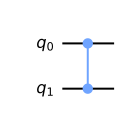

In [15]:
circ = QuantumCircuit(2)
circ.cz(0, 1)
circ.draw()

## 练习 4.19 (受控非门在密度矩阵上的作用)

:::{admonition} 练习 4.19

受控非门在密度矩阵 $\rho$ 上的作用是重排矩阵元素的位置，故仅为一置换。在计算基下清晰地写出它的作用。

:::

实际上，不仅对于密度矩阵，对于任意的 $4 \times 4$ 矩阵 $A$ 都是置换作用。我们令计算基下的 $A$ 矩阵：

In [16]:
A = np.array(np.zeros((4, 4)) + np.array([1, 2, 3, 4]) + np.array([10, 20, 30, 40])[:, None], dtype=int)
A

array([[11, 12, 13, 14],
       [21, 22, 23, 24],
       [31, 32, 33, 34],
       [41, 42, 43, 44]])

可以知道，$\mathrm{CNOT}_{x_1, x_2} A$ 的效应是将矩阵的第 3、4 行进行对调：

In [17]:
np.array(ctrl_1_X @ A, dtype=int)

array([[11, 12, 13, 14],
       [21, 22, 23, 24],
       [41, 42, 43, 44],
       [31, 32, 33, 34]])

可能更有意义的作用是 $\mathrm{CNOT}_{x_1, x_2} \, A \, \mathrm{CNOT}_{x_1, x_2}^\dagger$ 的效应是将第 3、4 行与第 3、4 列同时对调。我们同时注意到 $\mathrm{CNOT}_{x_1, x_2}$ 是 Hermitian 矩阵，即 $\mathrm{CNOT}_{x_1, x_2} = \mathrm{CNOT}_{x_1, x_2}^\dagger$。

In [18]:
np.array(ctrl_1_X @ A @ ctrl_1_X, dtype=int)

array([[11, 12, 14, 13],
       [21, 22, 24, 23],
       [41, 42, 44, 43],
       [31, 32, 34, 33]])

因此，操作 $\mathrm{CNOT}_{x_1, x_2} \, A \, \mathrm{CNOT}_{x_1, x_2}^\dagger$ 实际上相当于将计算基 $\{ |00\rangle, |01\rangle, |10\rangle, |11\rangle \}$ 转换到 $\{ |00\rangle, |01\rangle, |11\rangle, |10\rangle \}$。

## 练习 4.20 (受控非门的基变换)

:::{admonition} 练习 4.20

不像理想的经典门，理想的量子门没有 (如电子工程师说的) 高阻抗输入。实际上，“控制”和“目标”的角色是随意的——它们的区分依赖于你认为该设备在哪组基下计算。我们已经描述了受控非门相对计算基的行为，并且在这个描述中控制量子比特是不变的。然而，如果考虑一组不同的基，则控制量子比特的确要变：我们将看到依赖于“目标”量子比特的状态，它的相位要翻转。证明下图：

![ex-4.20.1](assets/ex-4.20.1.svg)

引入基状态组 $|\pm\rangle \equiv (|0\rangle \pm |1\rangle) / \sqrt{2}$，利用这个线路恒等式关系证明一个第一个量子比特作为控制、第二个量子比特作为目标的受控非门的作用为

$$
\begin{align*}
|+\rangle |+\rangle &\rightarrow |+\rangle |+\rangle \tag{4.24} \\
|-\rangle |+\rangle &\rightarrow |-\rangle |+\rangle \tag{4.25} \\
|+\rangle |-\rangle &\rightarrow |-\rangle |-\rangle \tag{4.26} \\
|-\rangle |-\rangle &\rightarrow |+\rangle |-\rangle \tag{4.27}
\end{align*}
$$

因此，相对这组新基，目标的量子比特的状态不变，而控制量子比特的状态在目标是 $|-\rangle$ 的时候翻转，否则保持不变；即在这组基下，目标和控制的角色实际上互换了。

:::

首先证明线路图等式。该线路图等式用数学语言表述，是

$$
\begin{align*}
(H \otimes H) \mathrm{CNOT}_{x_1, x_2} (H \otimes H) &= \mathrm{CNOT}_{x_2, x_1} \\
(H \otimes H) (P_0 \otimes I + P_1 \otimes X) (H \otimes H) &= I \otimes P_0 + X \otimes P_1
\end{align*}
$$

证明如下。我们需要利用到的结论有

$$
P_0 = \frac{I+Z}{2}, \quad P_1 = \frac{I-Z}{2}, \quad HXH=Z, \quad H^2 = I
$$

$$
\begin{align*}
\mathrm{LHS}
&= (H P_0 H) \otimes (H I H) + (H P_1 H) \otimes (H X H) \\
&= \frac{1}{2} \big( (HIH + HZH) \otimes I + (HIH - HZH) \otimes Z \big) \\
&= \frac{1}{2} \big( I \otimes I + X \otimes I + I \otimes Z - X \otimes Z \big) \\
&= \frac{1}{2} \big( I \otimes (I+Z) + X \otimes (I-Z) \big) \\
&= I \otimes P_0 + X \otimes P_1 = \mathrm{RHS}
\end{align*}
$$

我们当然也可以利用矩阵乘法直接证明等式：

In [19]:
np.allclose(
    np.kron(H, H) @ ctrl_1_X @ np.kron(H, H),
    ctrl_2_X)

True

---

第二个论断的另一种叙述方式是，若计算基下的态 $|x_1 x_2\rangle$ 等价于 $\{ |+\rangle, |-\rangle \}$ 基下的态 $|y_1 y_2\rangle$，那么 $\mathrm{CNOT}_{x_1, x_2}$ 作为 $x_1$ 控制、$x_2$ 目标的受控非门，在基 $\{ |+\rangle, |-\rangle \}$ 下恰好等价于 $\mathrm{CNOT}_{y_2, y_1}$ 即 $|y_2\rangle$ 控制、$|y_1\rangle$ 目标的受控非门。

实际上左乘 $H$，右乘 $H^\dagger = H$ 就相当于将算符的表示矩阵从计算基 $\{ |0\rangle, |1\rangle \}$ 转换到基 $\{ |+\rangle, |-\rangle \}$。依照这个思路，我们作如下简单的说明。我们首先要回顾到

$$
H |0\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}} = |+\rangle, \quad H |1\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}} = |-\rangle
$$

以及

$$
H |+\rangle = H^2 |0\rangle = |0\rangle, \quad H |-\rangle = H^2 |1\rangle = |1\rangle
$$

因此，

$$
\begin{align*}
\mathrm{CNOT}_{x_1, x_2} |+\rangle |+\rangle
&= \mathrm{CNOT}_{x_1, x_2} \big[ |+\rangle \otimes |+\rangle \big] \\
&= \mathrm{CNOT}_{x_1, x_2} \big[ \big( H |0\rangle \big) \otimes \big( H |0\rangle \big) \big] \\
&= \mathrm{CNOT}_{x_1, x_2} (H \otimes H) |0\rangle |0\rangle \\
&= (H \otimes H)^2 \mathrm{CNOT}_{x_1, x_2} (H \otimes H) |0\rangle |0\rangle \\
&= (H \otimes H) \mathrm{CNOT}_{x_2, x_1} |0\rangle |0\rangle \\
&= (H \otimes H) |0\rangle |0\rangle \\
&= \big( H |0\rangle \big) \otimes \big( H |0\rangle \big) = |+\rangle |+\rangle
\end{align*}
$$

上式中用到的技巧是 $(H \otimes H)^2 = I$。

类似地，

$$
\begin{align*}
\mathrm{CNOT}_{x_1, x_2} |+\rangle |-\rangle
&= \mathrm{CNOT}_{x_1, x_2} (H \otimes H) |0\rangle |1\rangle \\
&= (H \otimes H) \mathrm{CNOT}_{x_2, x_1} |0\rangle |1\rangle \\
&= (H \otimes H) |1\rangle |0\rangle = |-\rangle |+\rangle
\end{align*}
$$

对于 $|-\rangle |+\rangle, |-\rangle |-\rangle$ 来说，证明过程是类似的。

## 练习 4.21

:::{admonition} 练习 4.21

验证下图的 $C^2 (U)$ 的运算。

![ex-4.21.1](assets/ex-4.21.1.svg)

其中，$V^2 = U$，且 $U, V$ 均为酉算符。

:::

该练习尽管可以使用数学方法作证明，但过程非常繁琐。分类讨论是最快的处理方法。我们考察下图：

![ex-4.21.2](assets/ex-4.21.2.svg)

上图的过程是指，对于初始三粒子态 $|\psi_0\rangle = |x_1 x_2\rangle \otimes |x_3\rangle$，经过该门路后得到 $|\psi_5\rangle$。我们对 $|x_1 x_2\rangle = |00\rangle, |01\rangle, |10\rangle, |11\rangle$ 分别进行讨论。下面需要利用到酉矩阵的性质 $V V^\dagger = V^\dagger V = I$。

$$
\begin{alignat*}{20}
& |\psi_0\rangle && |\psi_1\rangle && |\psi_2\rangle && |\psi_3\rangle && |\psi_4\rangle && |\psi_5\rangle &&
\\
& \text{init}
&& \text{ctrl-}V_{x_2, x_3}
&& \mathrm{CNOT}_{x_1, x_2}
&& \text{ctrl-}V^\dagger_{x_2, x_3}
&& \mathrm{CNOT}_{x_1, x_2}
&& \text{ctrl-}V_{x_1, x_3}
&& \quad\text{equivalent}
\\
& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& = |00\rangle \otimes |x_3\rangle
\\
& |01\rangle \otimes |x_3\rangle \quad
&& |01\rangle \otimes V |x_3\rangle \quad
&& |01\rangle \otimes V |x_3\rangle \quad
&& |01\rangle \otimes V V^\dagger |x_3\rangle \quad
&& |01\rangle \otimes V V^\dagger |x_3\rangle \quad
&& |01\rangle \otimes V V^\dagger |x_3\rangle \quad
&& = |01\rangle \otimes |x_3\rangle
\\
& |10\rangle \otimes |x_3\rangle \quad
&& |10\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes V^\dagger |x_3\rangle \quad
&& |10\rangle \otimes V^\dagger |x_3\rangle \quad
&& |10\rangle \otimes V^\dagger V |x_3\rangle \quad
&& = |10\rangle \otimes |x_3\rangle
\\
& |11\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes V |x_3\rangle \quad
&& |10\rangle \otimes V |x_3\rangle \quad
&& |10\rangle \otimes V |x_3\rangle \quad
&& |11\rangle \otimes V |x_3\rangle \quad
&& |11\rangle \otimes V^2 |x_3\rangle \quad
&& = |11\rangle \otimes U |x_3\rangle
\end{alignat*}
$$

这其中，只有 $|11\rangle \otimes |x_3\rangle$ 给出了 $|11\rangle \otimes U |x_3\rangle$，其它情况都保持初态不变。因此，该门路从定义上确实符合 $x_1, x_2$ 为控制量子比特、$x_3$ 为目标量子比特的受控 $U$ 门路。

## 练习 4.22

:::{admonition} 练习 4.22

证明一个 $C^2 (U)$ 门 (对任意单量子比特酉算符 $U$) 可至多用 8 个单量子比特门和 6 个受控非门构造出来。

:::

该证明实际上还是比较精妙的。这里先给出大体的证明过程；但对于其中一部分细节，我们在后续的引理证明部分给出。

该题的参考资料是

> https://quantumcomputing.stackexchange.com/a/6951/14843

### 第一步：用 CNOT 与单量子比特酉算符表示 $C^2(U)$ 门

证明的第一步很容易。我们回顾到图 4.6，任意的酉矩阵 $V$ 总可以写为酉矩阵 $A, B, C$ 与实数相位参数 $\alpha$ 的表达式：

$$
\begin{gather*}
V = e^{i \alpha} A X B X C \\
ABC = I
\end{gather*}
$$

为了方便，我们定义下述相位算符：

$$
P_\alpha = \begin{bmatrix} 1 & 0 \\ 0 & e^{i \alpha} \end{bmatrix}
$$

因此，书中的图 4.6 可以表示如下 (注意为了这道例题的记号方便，我们有意用 $V$ 替代 $U$ 表示任意酉矩阵)：

![ex-4.22.1](assets/ex-4.22.1.svg)

其转置 $V = C^\dagger X B^\dagger X (e^{-i \alpha} A^\dagger)$ 也是容易给出的。我们只要将转换为自伴算符，并对调线路顺序即可：

![ex-4.22.2](assets/ex-4.22.2.svg)

我们将这两个线路代入图 4.8 即可 (红色线条隔开受控 $V$ 或 $V^\dagger$ 算符的代入区域)：

![ex-4.22.3](assets/ex-4.22.3.svg)

我们发现，上述的图像中，有两个可以简化的线路。所有蓝色虚线框中标出的部分实际上是恒等作用 $A A^\dagger = C^\dagger C = I$ (回顾到 $A, B, C$ 都是酉矩阵)，因此进一步简化为

![ex-4.22.4](assets/ex-4.22.4.svg)

到现在为止，我们简化到 8 个单量子比特门路、与 8 个 CNOT 门路。我们还需要减掉两个 CNOT 门路。下一步中，我们会先对上图中的蓝色区域所包含的 CNOT 作简化。

### 第二步：简化 CNOT 门路

这一步需要用到下述**引理一**：

![ex-4.22.5](assets/ex-4.22.5.svg)

我们可以立即简化得到 (这里仍然有 7 个 CNOT 门路，还没有达到要求)

![ex-4.22.9](assets/ex-4.22.9.svg)

注意到第三行的 $B^\dagger$ 门路与第一、二行的 CNOT 门路相互不受影响，因此我们交换一下这两个门路：

![ex-4.22.10](assets/ex-4.22.10.svg)

对上述蓝色区域使用**引理一推论**：

![ex-4.22.7](assets/ex-4.22.7.svg)

可以得到

![ex-4.22.11](assets/ex-4.22.11.svg)

### 第三步：相位转移

看起来问题又复杂化了，重新回到了 8 个 CNOT 门路。但实际上，依据**引理二**与**引理三**，上述蓝色虚线框中的部分可以比较随意地移动。迁移之后，得到

![ex-4.22.12](assets/ex-4.22.12.svg)

橙色的区域是两个相同的 CNOT 算符。由于 CNOT 算符在双量子比特空间下是实对称酉算符，因此可以相互抵消。最终，我们得到

![ex-4.22.13](assets/ex-4.22.13.svg)

### 引理一：CNOT 门路简化

我们需要证明下述路线图：

![ex-4.22.6](assets/ex-4.22.6.svg)

证明方法与练习 4.21 相同。我们对等式左作考察：

$$
\begin{alignat*}{20}
& |\psi_0\rangle && |\psi_1\rangle && |\psi_2\rangle && |\psi_3\rangle &&
\\
& \text{init}
&& \mathrm{CNOT}_{x_2, x_3}
&& \mathrm{CNOT}_{x_1, x_2}
&& \mathrm{CNOT}_{x_1, x_3}
&& \quad\text{equivalent}
\\
& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& = |00\rangle \otimes |x_3\rangle
\\
& |01\rangle \otimes |x_3\rangle \quad
&& |01\rangle \otimes X |x_3\rangle \quad
&& |01\rangle \otimes X |x_3\rangle \quad
&& |01\rangle \otimes X |x_3\rangle \quad
&& = |01\rangle \otimes X |x_3\rangle
\\
& |10\rangle \otimes |x_3\rangle \quad
&& |10\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes X |x_3\rangle \quad
&& = |11\rangle \otimes X |x_3\rangle
\\
& |11\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes X |x_3\rangle \quad
&& |10\rangle \otimes X |x_3\rangle \quad
&& |10\rangle \otimes X^2 |x_3\rangle \quad
&& = |10\rangle \otimes |x_3\rangle
\end{alignat*}
$$

再对等式右作考察：

$$
\begin{alignat*}{20}
& |\psi_0\rangle && |\psi_4\rangle && |\psi_5\rangle
\\
& \text{init}
&& \mathrm{CNOT}_{x_1, x_2}
&& \mathrm{CNOT}_{x_2, x_3}
\\
& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle \quad
&& |00\rangle \otimes |x_3\rangle
\\
& |01\rangle \otimes |x_3\rangle \quad
&& |01\rangle \otimes |x_3\rangle \quad
&& |01\rangle \otimes X |x_3\rangle \quad
\\
& |10\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes |x_3\rangle \quad
&& |11\rangle \otimes X |x_3\rangle
\\
& |11\rangle \otimes |x_3\rangle \quad
&& |10\rangle \otimes X |x_3\rangle \quad
&& |10\rangle \otimes |x_3\rangle
\end{alignat*}
$$

我们就发现 $|\psi_3\rangle = |\psi_5\rangle$，即等式两边相等。

### 引理一推论

我们给出下述等式关系：

![ex-4.22.8](assets/ex-4.22.8.svg)

我们对**引理一**的等式左右取自伴算符，随后对调等式左右，就得到上式的第一个等号。

第二个等号相当于一种对易关系：

$$
\big[ \mathrm{CNOT}_{x_1, x_3}, \mathrm{CNOT}_{x_1, x_2} \mathrm{CNOT}_{x_2, x_3} \big] = 0
$$

对于这个对易，它是比较容易看出来的，我们不作仔细证明。

- 我们说，$\mathrm{CNOT}_{x_1, x_3}$ 对于对目标量子比特 $|x_3\rangle$ 的作用是 $X$ 或 $I$。而其它可能对 $|x_3\rangle$ 产生作用的算符是 $\mathrm{CNOT}_{x_2, x_3}$，它也是 $X$ 或 $I$。因此，可能作用于 $|x_3\rangle$ 上的所有算符都相互对易。
- 同时，$|x_1\rangle$ 的作用仅仅是控制，因此 $|x_1\rangle$ 的值始终不变。
- 综合上面的两点考虑，$\mathrm{CNOT}_{x_1, x_3}$ 的位置在这个门路中是可以任意交换。

但我们也必须要说明，$\mathrm{CNOT}_{x_1, x_2}$ 与 $\mathrm{CNOT}_{x_2, x_3}$ 在门路中不可以交换。这个由读者自行验证吧。一般来说，如果一个量子比特同时可能作为控制比特出现，也被单量子比特算符作用或作为目标比特作用，那么这些算符之间不可交换。

### 引理二：对角算符在受控门路下的平移

我们之前说到，一般来说，不是所有算符都可以与 CNOT 的控制部分作对换。一个简单的例子会是

![ex-4.22.14](assets/ex-4.22.14.svg)

但我们马上会证明下述结论。对于任意的对角矩阵 $\Lambda$ 与受控 $A$ 门路 (未必要求是酉矩阵)，其门路满足下式

![ex-4.22.15](assets/ex-4.22.15.svg)

既然 $\Lambda$ 是对角矩阵，那么它一定能通过参数 $\lambda_0, \lambda_1 \in \mathbb{C}^2$ 表示：

$$
\Lambda = \begin{bmatrix} \lambda_0 & 0 \\ 0 & \lambda_1 \end{bmatrix} = \lambda_0 P_0 + \lambda_1 P_1
$$

那么

$$
\begin{align*}
\mathrm{RHS} &= (\Lambda \otimes I) (P_0 \otimes I + P_1 \otimes A) = (\lambda_0 P_0 \otimes I + \lambda_1 P_1 \otimes I) (P_0 \otimes I + P_1 \otimes A) \\
&= \lambda_0 P_0^2 \otimes I^2 + \lambda_1 P_1^2 \otimes IA + \big( \text{terms involves } P_0 P_1 = P_1 P_0 = 0 \big) \\
&= (P_0 \otimes I + P_1 \otimes A) (\lambda_0 P_0 \otimes I + \lambda_1 P_1 \otimes I) \\
&= (P_0 \otimes I + P_1 \otimes A) (\Lambda \otimes I) = \mathrm{LHS}
\end{align*}
$$

### 引理三

![ex-4.22.16](assets/ex-4.22.16.svg)

该引理不作证明。直接代入矩阵定义很容易给予证明。引理三是要表明，该符合算符在双量子比特空间下为对角矩阵，因此可以利用**引理二**，该符合算符可以与原问题的第一行或第二行控制节点进行交换。

## 练习 4.23

:::{admonition} 练习 4.23

仅用受控非门和单量子比特门构造一个 $U = R_x(\theta)$ 和 $U = R_y(\theta)$ 的 $C^1(U)$ 门。你能够把所需的单量子比特门的数量减到三个或两个吗？

:::

我们先构造较为简单的受控 $R_y(\theta)$。回顾练习 4.7，我们有

$$
R_y(\theta) = X R_y(-\theta) X
$$

因此，我们构造下述矩阵拆分：

$$
R_y(\theta) = e^{i \alpha} AXBXC = X R_y(-\theta/2) X R_y(\theta/2)
$$

其中，$\alpha = 0$、$A = I$、$B = R_y(-\theta/2)$、$C = R_y(\theta/2)$。容易证明 $ABC = I$。因此，

![ex-4.23.1](assets/ex-4.23.1.svg)

类似地，我们也能得到 $R_z (\theta) = X R_z (-\theta) X$。但我们还能同时得到另一个结论：

$$
R_x(\theta) = H R_z(\theta) H
$$

证明过程很简单。套用式 (4.4, 4.6, 4.18)，可以得到

$$
\begin{align*}
R_x(\theta) &= \cos \frac{\theta}{2} I - i \sin \frac{\theta}{2} X \\
&= \cos \frac{\theta}{2} H^2 - i \sin \frac{\theta}{2} HZH \\
&= H \left( \cos \frac{\theta}{2} I - i \sin \frac{\theta}{2} Z \right) \\
&= H R_z(\theta) H
\end{align*}
$$

基于上述结论，以及仿照 $R_y$ 的矩阵拆解

$$
R_z(\theta) = X R_z(-\theta/2) X R_z(\theta/2)
$$

我们立即可以得到

$$
\begin{align*}
R_x(\theta) &= e^{i \alpha} AXBXC \\
&= H R_z(\theta) H = H X R_z(-\theta/2) X R_z(\theta/2) H
\end{align*}
$$

其中，$\alpha = 0$、$A = H$、$B = R_z(-\theta/2)$、$C = R_z(\theta/2) H$。同样容易证明 $ABC = I$。因此，

![ex-4.23.2](assets/ex-4.23.2.svg)

## 练习 4.24

:::{admonition} 练习 4.24

验证图 4.9 所实现的 Toffoli 门。

![ex-4.24.1](assets/ex-4.24.1.svg)

:::

我们这里采用与原来书中稍有不同的记号。我们令

$$
V = \frac{(1 + i) (I - i X)}{2}
$$

它具有性质 $V^2 = X$。

In [20]:
V = 0.5 * (1 + 1j) * (I - 1j * X)
V

array([[0.5+0.5j, 0.5-0.5j],
       [0.5-0.5j, 0.5+0.5j]])

In [21]:
np.allclose(V.conj() @ V.conj(), X)

True

可以验证 $V$ 具有如下分解：

$$
\begin{gather*}
A = H T, \quad B = T^\dagger, \quad C = H, \quad \alpha = \pi / 4 \\
V = e^{i \alpha} AXBXC
\end{gather*}
$$

In [22]:
A = H @ T
B = T.conj().T
C = H
α = np.pi / 4
np.allclose(np.exp(1j * α) * A @ X @ B @ X @ C, V)

True

那么依据练习 4.22 的结论，我们立即能得到

![ex-4.24.2](assets/ex-4.24.2.svg)

---

上图与待证的图 4.9 在线路图的第一、二行上稍有差别。第一行依据练习 4.22 的引理二，容易知道其实是等价的，即第一行的 $T$ 门位置并不重要。对于第二行，我们需要表明 (下图中的 $S = T^2$)

![ex-4.24.3](assets/ex-4.24.3.svg)

第一个量子比特是控制比特，等式左右当然是相等的。我们要分别考察第二个目标量子比特在第一个比特为 $|0\rangle, |1\rangle$ 时的行为。对于控制量子比特为 $|0\rangle$ 时，上图的等式证明问题就化为

$$
T^\dagger T = S T^\dagger T^\dagger
$$

这个结论是比较显然的，等式左右为恒等算符。

In [23]:
np.allclose(
    T.conj().T @ T,
    S @ T.conj().T @ T.conj().T)

True

控制量子比特为 $|1\rangle$ 时，上图的等式证明就化为

$$
X T^\dagger X T = S X T^\dagger X T^\dagger
$$

In [24]:
np.allclose(
    X @ T.conj().T @ X @ T,
    S @ X @ T.conj().T @ X @ T.conj().T)

True

因此，上图的等式成立。到这里，我们就借着练习 4.22 的结论，完成了 Toffoli 门的证明。

## 练习 4.25 (Fredkin 门的构造)

:::{admonition} 练习 4.25

回忆 Fredkin (受控交换，controlled-swap) 门进行的运算：

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

1. 给出使用三个 Toffoli 门构造的 Fredkin 门 (提示：想想这个交换门的结构——可以每次控制一个门)。
2. 证明第一个和最后一个 Toffoli 门可以用受控非门代替。
3. 用图 4.8 所示线路代替中间的 Toffoli 门，来得到仅用 6 个双量子比特门所构造的 Fredkin 门。
4. 有更简单的仅用 5 个双量子比特门的结构吗？

:::

**第一问**

首先我们要验证交换门路：

![ex-4.25.1](assets/ex-4.25.1.svg)

我们假设态处于 $|x_1\rangle |x_2\rangle$，其中 $x_1, x_2 \in \{0, 1\}$。那么

- 经过第一个 CNOT，得到 $|x_1\rangle |x_2 \oplus x_1\rangle$；
- 经过第二个 CNOT，得到 $|x_1 \oplus (x_2 \oplus x_1)\rangle |x_2 \oplus x_1\rangle = |x_2\rangle |x_2 \oplus x_1\rangle$；
- 经过第三个 CNOT，得到 $|x_2\rangle |(x_2 \oplus x_1) \oplus x_2\rangle = |x_2\rangle |x_1\rangle$；

这就将 $|x_1\rangle |x_2\rangle$ 转换到了 $|x_2\rangle |x_1\rangle$。

因此，受控交换门只是再加上了一个控制节点而已：

![ex-4.25.2](assets/ex-4.25.2.svg)

---

**第二问**

这一问答案是

![ex-4.25.3](assets/ex-4.25.3.svg)

比较正常的解法会是对该算符考察其真值表 (原书中图 3.15)。当然，我们也可以用数学的语言来证明。上图的三量子比特下的 CNOT 门 (等式右的左右两个门路) 可以写为 $I \otimes \mathrm{CNOT}$，而等式右的中间 Toffoli 门表示为 $I^{\otimes 3} + P_1 \otimes (X-I) \otimes P_1$。我们需要证明的是

$$
\text{ctrl-swap} = \big( I \otimes \mathrm{CNOT} \big) \big( I^{\otimes 3} + P_1 \otimes (X-I) \otimes P_1 \big) \big( I \otimes \mathrm{CNOT} \big)
$$

In [25]:
ctrl_12_X = np.kron(I, ctrl_1_X)
ctrl_13_toff = np.eye(8) + np.kron(np.kron(P1, X-I), P1)
ctrl_12_X @ ctrl_13_toff @ ctrl_12_X

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

上述的计算结果与题目所给出的 Fredkin 门矩阵表示完全一致。

---

**第三问**

由于交换算符的对称性，门路的第二、三行可以互相交换。为了方便起见，我们交换这两行，并代入图 4.8：

![ex-4.25.4](assets/ex-4.25.4.svg)

---

**第四问**

这里需要利用到一些对易关系。首先，利用到 $V V^\dagger = V^\dagger V = I$ 的对易关系，可以表明左数第 6 个门路与左数 3, 4, 5 门路可以交换。因此，

![ex-4.25.5](assets/ex-4.25.5.svg)

随后利用到 $[X, X] = 0$ 的关系，右数第 1, 2 个门路可以对易。因此，

![ex-4.25.6](assets/ex-4.25.6.svg)

上图中的五个蓝色虚线框，就是题目所要求的 5 个双量子比特门路。

本题的参考资料是

> https://journals.aps.org/pra/abstract/10.1103/PhysRevA.53.2855

## 练习 4.26

:::{admonition} 练习 4.26

证明如下线路

![ex-4.26.1](assets/ex-4.26.1.svg)

与 Toffoli 门的差别仅是相对相位。即该线路把 $|c_1, c_2, t\rangle$ 变为 $e^{i \theta(c_1, c_2, t)} |c_1, c_2, t \oplus c_1 c_2\rangle$，其中 $e^{i \theta(c_1, c_2, t)}$ 是某个相对相位因子。这类门在实验实现中有时有用，它可以实现除了一个相对相位外与 Toffoli 门相同的门，但比直接实现 Toffoli 门容易得多。

:::

本题使用练习 4.21 的解法会比较方便。我们同时回顾到练习 4.7 的结论 $X R_y(\theta) X = R_y(-\theta)$ 以及 $X^2 = 1$。那么，我们考察不同的 $c_1, c_2$ 下，第三行算符的实际作用 (注意算符图上线路的顺序与矩阵乘法顺序是反过来的)：

$$
\begin{align*}
(c_0, c_1) = (0, 0)
&\rightarrow R_y\left(- \frac{\pi}{4}\right) R_y\left(- \frac{\pi}{4}\right) R_y\left(\frac{\pi}{4}\right) R_y\left(\frac{\pi}{4}\right) = I \\
(c_0, c_1) = (0, 1)
&\rightarrow R_y\left(- \frac{\pi}{4}\right) X \underline{R_y\left(- \frac{\pi}{4}\right) R_y\left(\frac{\pi}{4}\right)} X R_y\left(\frac{\pi}{4}\right) \\
&= R_y\left(- \frac{\pi}{4}\right) X I X R_y\left(\frac{\pi}{4}\right) = I \\
(c_0, c_1) = (1, 0)
&\rightarrow \underline{R_y\left(- \frac{\pi}{4}\right) R_y\left(- \frac{\pi}{4}\right)} X \underline{R_y\left(\frac{\pi}{4}\right) R_y\left(\frac{\pi}{4}\right)} \\
&= R_y\left(- \frac{\pi}{2}\right) \underline{X R_y\left(\frac{\pi}{2}\right) X} X \\
&= \underline{R_y\left(- \frac{\pi}{2}\right) R_y\left(- \frac{\pi}{2}\right)} X \\
&= R_y\left(- \pi\right) X = Z \\
(c_0, c_1) = (1, 1)
&\rightarrow R_y\left(- \frac{\pi}{4}\right) X R_y\left(- \frac{\pi}{4}\right) \underline{X R_y\left(\frac{\pi}{4}\right) X} R_y\left(\frac{\pi}{4}\right) \\
&= R_y\left(- \frac{\pi}{4}\right) X \underline{R_y\left(- \frac{\pi}{4}\right) R_y\left(- \frac{\pi}{4}\right) X R_y\left(\frac{\pi}{4}\right)} \\
&= X \underline{X R_y\left(- \frac{\pi}{4}\right) X R_y\left(- \frac{\pi}{4}\right)} = X
\end{align*}
$$

这里比较特殊的是 $(c_0, c_1) = (1, 0)$ 的情况。该控制门路的作用是将 $|t\rangle$ 变为 $Z |t\rangle$，而不是恒等变换。但我们也注意到，$Z$ 的作用等同于相位门 $P_\pi = S^2 = T^4$。因此，对于这种特殊情况，确实可以认为是相差一个相位；但这个相位是 $|t\rangle$ 中 $|0\rangle$ 与 $|1\rangle$ 的贡献分量相位之区别，而不是全局相位 $e^{i \theta(c_1, c_2, t)}$。因此我倾向于认为，题目的问法是错的。

## 练习 4.27

:::{admonition} 练习 4.27

仅用受控非门和 Toffoli 门，来构造一个执行如下变换的量子线路。

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}
$$

这类部分循环置换 (cyclic permutation) 运算将在后面第 7 章用到。

:::

很遗憾的是，这道题的答案目前还是凑出来的。但是我们至少可以验证下述结果。

![ex-4.27.1](assets/ex-4.27.1.svg)

仍然按照练习 4.21 的做法，对每个可能的波函数进行讨论：

$$
\begin{alignat*}{20}
& \mathrm{init}\; && \mathrm{Toffoli}_{x_2 x_3, x_1}\; && \mathrm{CNOT}_{x_3, x_2}\; && \mathrm{CNOT}_{x_2, x_3}\; && \mathrm{CNOT}_{x_1, x_2}\; && \mathrm{Toffoli}_{x_1 x_2, x_3}\; && \mathrm{CNOT}_{x_1, x_2} \\
& |000\rangle\; && |000\rangle && |000\rangle && |000\rangle && |000\rangle && |000\rangle && |000\rangle && \\
& |001\rangle\; && |001\rangle && |011\rangle && |010\rangle && |010\rangle && |010\rangle && |010\rangle && \\
& |010\rangle\; && |010\rangle && |010\rangle && |011\rangle && |011\rangle && |011\rangle && |011\rangle && \\
& |011\rangle\; && |111\rangle && |101\rangle && |101\rangle && |111\rangle && |110\rangle && |100\rangle && \\
& |100\rangle\; && |100\rangle && |100\rangle && |100\rangle && |110\rangle && |111\rangle && |101\rangle && \\
& |101\rangle\; && |101\rangle && |111\rangle && |110\rangle && |100\rangle && |100\rangle && |110\rangle && \\
& |110\rangle\; && |110\rangle && |110\rangle && |111\rangle && |101\rangle && |101\rangle && |111\rangle && \\
& |111\rangle\; && |011\rangle && |001\rangle && |001\rangle && |001\rangle && |001\rangle && |001\rangle && \\
\end{alignat*}
$$

上表满足题目所要求的循环置换的矩阵表示结果。

---

我们也可以利用 Python 代码结合 Qiskit 实现。但需要注意，由于原书中的量子比特记号约定是 $|x_1 x_2 x_3\rangle$，但在 Qiskit 中则是 $|x_3 x_2 x_1\rangle$，因此为了得到与书中相同的矩阵表示，我们需要额外增加两个 SWAP 门路。作为答案的线路，在下图中是被灰色虚线所围起来的线路。

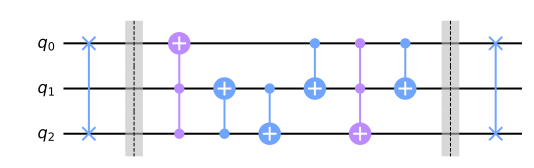

In [26]:
circ = QuantumCircuit(3)
circ.swap(0, 2)
circ.barrier()
circ.toffoli(1, 2, 0)
circ.cnot(2, 1)
circ.cnot(1, 2)
circ.cnot(0, 1)
circ.toffoli(0, 1, 2)
circ.cnot(0, 1)
circ.barrier()
circ.swap(0, 2)
circ.draw()

我们可以用下述代码，打出其矩阵表示。可以发现，该矩阵表示结果与题目要求完全相同。

In [27]:
np.asarray(Operator(circ).data, dtype=int)

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0]])

---

但本题最为直观的构造方式是，先对量子比特作加法，随后若 $|x_1 x_2, x_3\rangle = |00, x_3\rangle$，那么将其变换为 $|00, x_3\oplus1\rangle$。其实际操作过程非常直观：

$$
\begin{alignat*}{20}
& \mathrm{init}\; && \mathrm{Addition}\; && \mathrm{Control} \\
& |000\rangle\; && |001\rangle && |000\rangle && \\
& |001\rangle\; && |010\rangle && |010\rangle && \\
& |010\rangle\; && |011\rangle && |011\rangle && \\
& |011\rangle\; && |100\rangle && |100\rangle && \\
& |100\rangle\; && |101\rangle && |101\rangle && \\
& |101\rangle\; && |110\rangle && |110\rangle && \\
& |110\rangle\; && |111\rangle && |111\rangle && \\
& |111\rangle\; && |000\rangle && |001\rangle && \\
\end{alignat*}
$$

- 加法的线路构造思路是，需要在 $|x_3\rangle$ 引入 $X$ 算符以实现 $|x_3 \oplus 1\rangle$，随后小心地通过引入控制门路以作合适的进位。
- 控制部分 $|x_1 x_2, x_3\rangle = |00, x_3\rangle$ 线路，实际上就是以 $|x_1 x_2\rangle = |00\rangle$ 来控制的 Toffoli 线路；我们回顾到先前定义的所有 Toffoli 线路都是以 $|x_1 x_2\rangle = |11\rangle$ 控制的；因此，依照书中的图 4.11 或图 4.12，可以给出该控制线路。

下图的蓝色区域即是加法线路，橙色区域即是控制线路。该线路也是本题的一个解，且构造思路清晰；但由于包含了单量子比特 $X$ 门路，因此并不满足题目的要求。

![ex-4.27.2](assets/ex-4.27.2.svg)

## 练习 4.28

:::{admonition} 练习 4.28

对于 $U = V^2$，其中 $V$ 是酉的，使用类似于图 4.10 的方式构造 $C^5 (U)$ 门，但不用工作量子比特，可以使用受控 $V$ 门与受控 $V^\dagger$ 门。

:::

:::{danger}

本题无解。无解性的证明思路是作行列式值分析。详细的理由请参考

> https://cs.stackexchange.com/a/138853/141343

如果我们允许多控制节点的非门或 $V$ 门，那么 $C^5 (U)$ 门是可以构造出来的：

![ex-4.28.1](assets/ex-4.28.1.svg)

同时，若定义 $U = V^{16}$，那么该练习也是可以完成的，但线路恐怕会非常复杂。

:::

## 练习 4.29, 4.30

:::{admonition} 练习 4.29

不使用工作量子比特，求出一个包含 $O(n^2)$ Toffoli 门、受控非门和单量子比特门的可实现 $C^n(X)$ 门 ($n > 3$) 的线路。

:::

:::{admonition} 练习 4.30

设 $U$ 是一个单量子比特酉运算，不使用工作量子比特，求一个包含 $O(n^2)$ Toffoli 门、受控非门和单量子比特门，实现 $C^n (U)$ 门 ($n>3$) 的线路。

:::

:::{warning}

这两个问题不在此作证明。

可以参考下述文献的 Corollary 7.6。尽管证明过程还算比较直观，但需要引入许多符号，证明过程也比较长。

> https://arxiv.org/abs/quant-ph/9503016

同时需要指出，对于任意 $n > 5$，如果允许一个工作量子比特，那么依据 Corollary 7.4，多受控非门的门路复杂度可以从 $O(n^2)$ 降为 $O(n)$。从这个角度来说，工作量子比特其实还是非常重要的。工作量子比特在这个问题中，或可能在其它问题中，可以对线路大大作简化。

:::

## 练习 4.31 (更多的线路恒等式)

:::{admonition} 练习 4.31

令下标表示算符作用的量子比特、并令 $C$ 是量子比特 1 为控制、量子比特 2 为目标的受控非门。证明如下恒等式：

$$
\begin{align*}
C X_1 C &= X_1 X_2 \tag{4.32} \\
C Y_1 C &= Y_1 X_2 \tag{4.33} \\
C Z_1 C &= Z_1 \tag{4.34} \\
C X_2 C &= X_2 \tag{4.35} \\
C Y_2 C &= Z_1 Y_2 \tag{4.36} \\
C Z_2 C &= Z_1 Z_2 \tag{4.37} \\
R_{z,1} (\theta) C &= C R_{z,1} (\theta) \tag{4.38} \\
R_{x,2} (\theta) C &= C R_{x,2} (\theta) \tag{4.39}
\end{align*}
$$

:::

### 记号的细化定义

我们回顾到 $C$ 即 CNOT 门，因此

$$
C = P_0 \otimes I + P_1 \otimes X
$$

$X_1$ 是只作用于第一个量子比特的门路，因此

$$
X_1 = X \otimes I
$$

仿上，其它的符号也可以相应地给予定义。

### 式 (4.32)

![ex-4.31.1](assets/ex-4.31.1.svg)

$$
\begin{align*}
C X_1 C &= (P_0 \otimes I + P_1 \otimes X) (X \otimes I) (P_0 \otimes I + P_1 \otimes X) \\
&= P_0 X P_0 \otimes I I I + P_0 X P_1 \otimes I I X + P_1 X P_0 \otimes X I I + P_1 X P_1 \otimes X I X \\
&= 0 \otimes I + (P_0 X P_1 + P_1 X P_0) \otimes X + 0 \otimes I \\
&= X \otimes X = (X \otimes I) (I \otimes X) = X_1 X_2
\end{align*}
$$

上式中，我们利用了 $P_0 X P_1 + P_1 X P_0 = I$ 以及 $P_0 X P_0 = P_1 X P_1 = 0$。这些可以通过矩阵乘法简单地验证，当然也可以用 $Z, I$ 的表达式展开 $P_0, P_1$ 来求解。

### 式 (4.33)

![ex-4.31.2](assets/ex-4.31.2.svg)

$$
\begin{align*}
C Y_1 C &= (P_0 \otimes I + P_1 \otimes X) (Y \otimes I) (P_0 \otimes I + P_1 \otimes X) \\
&= P_0 Y P_0 \otimes I I I + P_0 Y P_1 \otimes I I X + P_1 Y P_0 \otimes X I I + P_1 Y P_1 \otimes X I X \\
&= 0 \otimes I + (P_0 Y P_1 + P_1 Y P_0) \otimes X + 0 \otimes I \\
&= Y \otimes X = (Y \otimes I) (I \otimes X) = Y_1 X_2
\end{align*}
$$

上式中，我们利用了 $P_0 Y P_1 + P_1 Y P_0 = Y$ 以及 $P_0 Y P_0 = P_1 Y P_1 = 0$。

### 式 (4.34)

![ex-4.31.3](assets/ex-4.31.3.svg)

$$
\begin{align*}
C Z_1 C &= (P_0 \otimes I + P_1 \otimes X) (Z \otimes I) (P_0 \otimes I + P_1 \otimes X) \\
&= P_0 Z P_0 \otimes I I I + P_0 Z P_1 \otimes I I X + P_1 Z P_0 \otimes X I I + P_1 Z P_1 \otimes X I X \\
&= P_0 Z P_0 \otimes I + 0 \otimes X + 0 \otimes X + P_1 Z P_1 \otimes I \\
&= Z \otimes I = Z_1
\end{align*}
$$

上式中，我们利用了 $P_0 Z P_0 + P_1 Z P_1 = Z$ 以及 $P_0 Z P_1 = P_1 Z P_0 = 0$。

### 式 (4.35)

![ex-4.31.4](assets/ex-4.31.4.svg)

$$
\begin{align*}
C X_2 C &= (P_0 \otimes I + P_1 \otimes X) (I \otimes X) (P_0 \otimes I + P_1 \otimes X) \\
&= P_0 I P_0 \otimes I X I + P_0 I P_1 \otimes I X X + P_1 I P_0 \otimes X X I + P_1 I P_1 \otimes X X X \\
&= P_0 \otimes X + 0 \otimes I + 0 \otimes I + P_1 \otimes X \\
&= I \otimes X = X_2
\end{align*}
$$

上式中，我们利用了 Pauli 矩阵所具有的性质 $X^2 = Y^2 = Z^2 = I$、投影算符的幂等性 $P_0^2 = P_0$ 及 $P_1^2 = P_1$，和投影算符性质 $P_0 + P_1 = I$。

### 式 (4.36)

![ex-4.31.5](assets/ex-4.31.5.svg)

$$
\begin{align*}
C Y_2 C &= (P_0 \otimes I + P_1 \otimes X) (I \otimes Y) (P_0 \otimes I + P_1 \otimes X) \\
&= P_0 I P_0 \otimes I Y I + P_0 I P_1 \otimes I Y X + P_1 I P_0 \otimes X Y I + P_1 I P_1 \otimes X Y X \\
&= P_0 \otimes Y - P_1 \otimes Y \\
&= Z \otimes Y = (Z \otimes I) (I \otimes Y) = Z_1 Y_2
\end{align*}
$$

上式中，我们利用了 $Z$ 在投影算符下的展开 $Z = P_0 - P_1$，以及一个恒等式 $X Y X = iZX = i^2 Y = -Y$。

### 式 (4.37)

![ex-4.31.6](assets/ex-4.31.6.svg)

$$
\begin{align*}
C Z_2 C &= (P_0 \otimes I + P_1 \otimes X) (I \otimes Z) (P_0 \otimes I + P_1 \otimes X) \\
&= P_0 I P_0 \otimes I Z I + P_0 I P_1 \otimes I Z X + P_1 I P_0 \otimes X Z I + P_1 I P_1 \otimes X Z X \\
&= P_0 \otimes Z - P_1 \otimes Z \\
&= Z \otimes Z = (Z \otimes I) (I \otimes Z) = Z_1 Z_2
\end{align*}
$$

上式中，我们利用了一个恒等式 $X Z X = iXY = i^2 Z = -Z$。

### 式 (4.38)

![ex-4.31.7](assets/ex-4.31.7.svg)

我们知道 $R_z (\theta)$ 是对角矩阵，因此可以与控制节点交换。这是练习 4.22 证明过程中的引理二所告诉我们的。

### 式 (4.39)

![ex-4.31.8](assets/ex-4.31.8.svg)

我们知道 $R_x (\theta)$ 在目标量子比特上，与控制非门的非门 $X$ 是可以交换的。因此，上式成立。